In [1]:
from graph_utils import generate_graph, graph_to_jraph
import networkx as nx
import matplotlib.pyplot as plt
import jraph

from vertex_cover_A import train
from gcn import GCN, TrainState
import flax.linen as nn
import optax

from jax import Array
from jax.typing import ArrayLike

## Running the model on a single graph

We begin by only feeding the model a single graph

In [2]:
n_nodes = 100
p = 0.05

nx_graph, pos = generate_graph(n_nodes, prob=0.05, graph_type="erdos", random_seed=0)
jraph_graph = graph_to_jraph(nx_graph)

hidden_size = 100
n_class = 1
num_layers = 1
num_convolutions = 2
dropout_rate = 0.0

n_epochs = 10000
lr = 0.001

In [3]:
optimizer = optax.adam(learning_rate=lr)

net = GCN(
    hidden_size,
    n_class,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    output_activation=nn.sigmoid,
    num_convolutions=num_convolutions,
)

state, losses, evals = train(
    jraph_graph,
    net,
    optimizer,
    n_epochs,
    tol=0.01,
    patience=250,
    warm_up=100,
)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Early stopping at epoch 737


(36.4, 100.0)

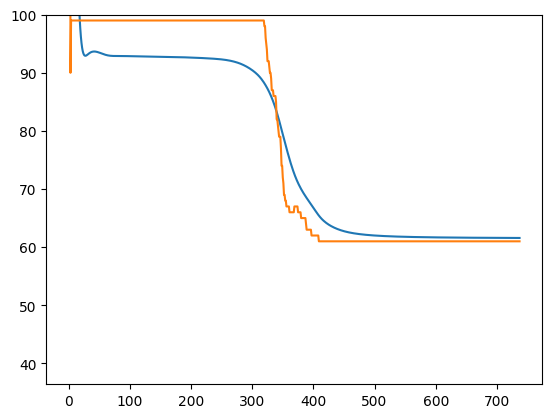

In [4]:
plt.plot(losses)
plt.plot(evals)
plt.ylim(top=100)

Violations: 0
Unnecessary nodes: 0
Approximate cover: 80


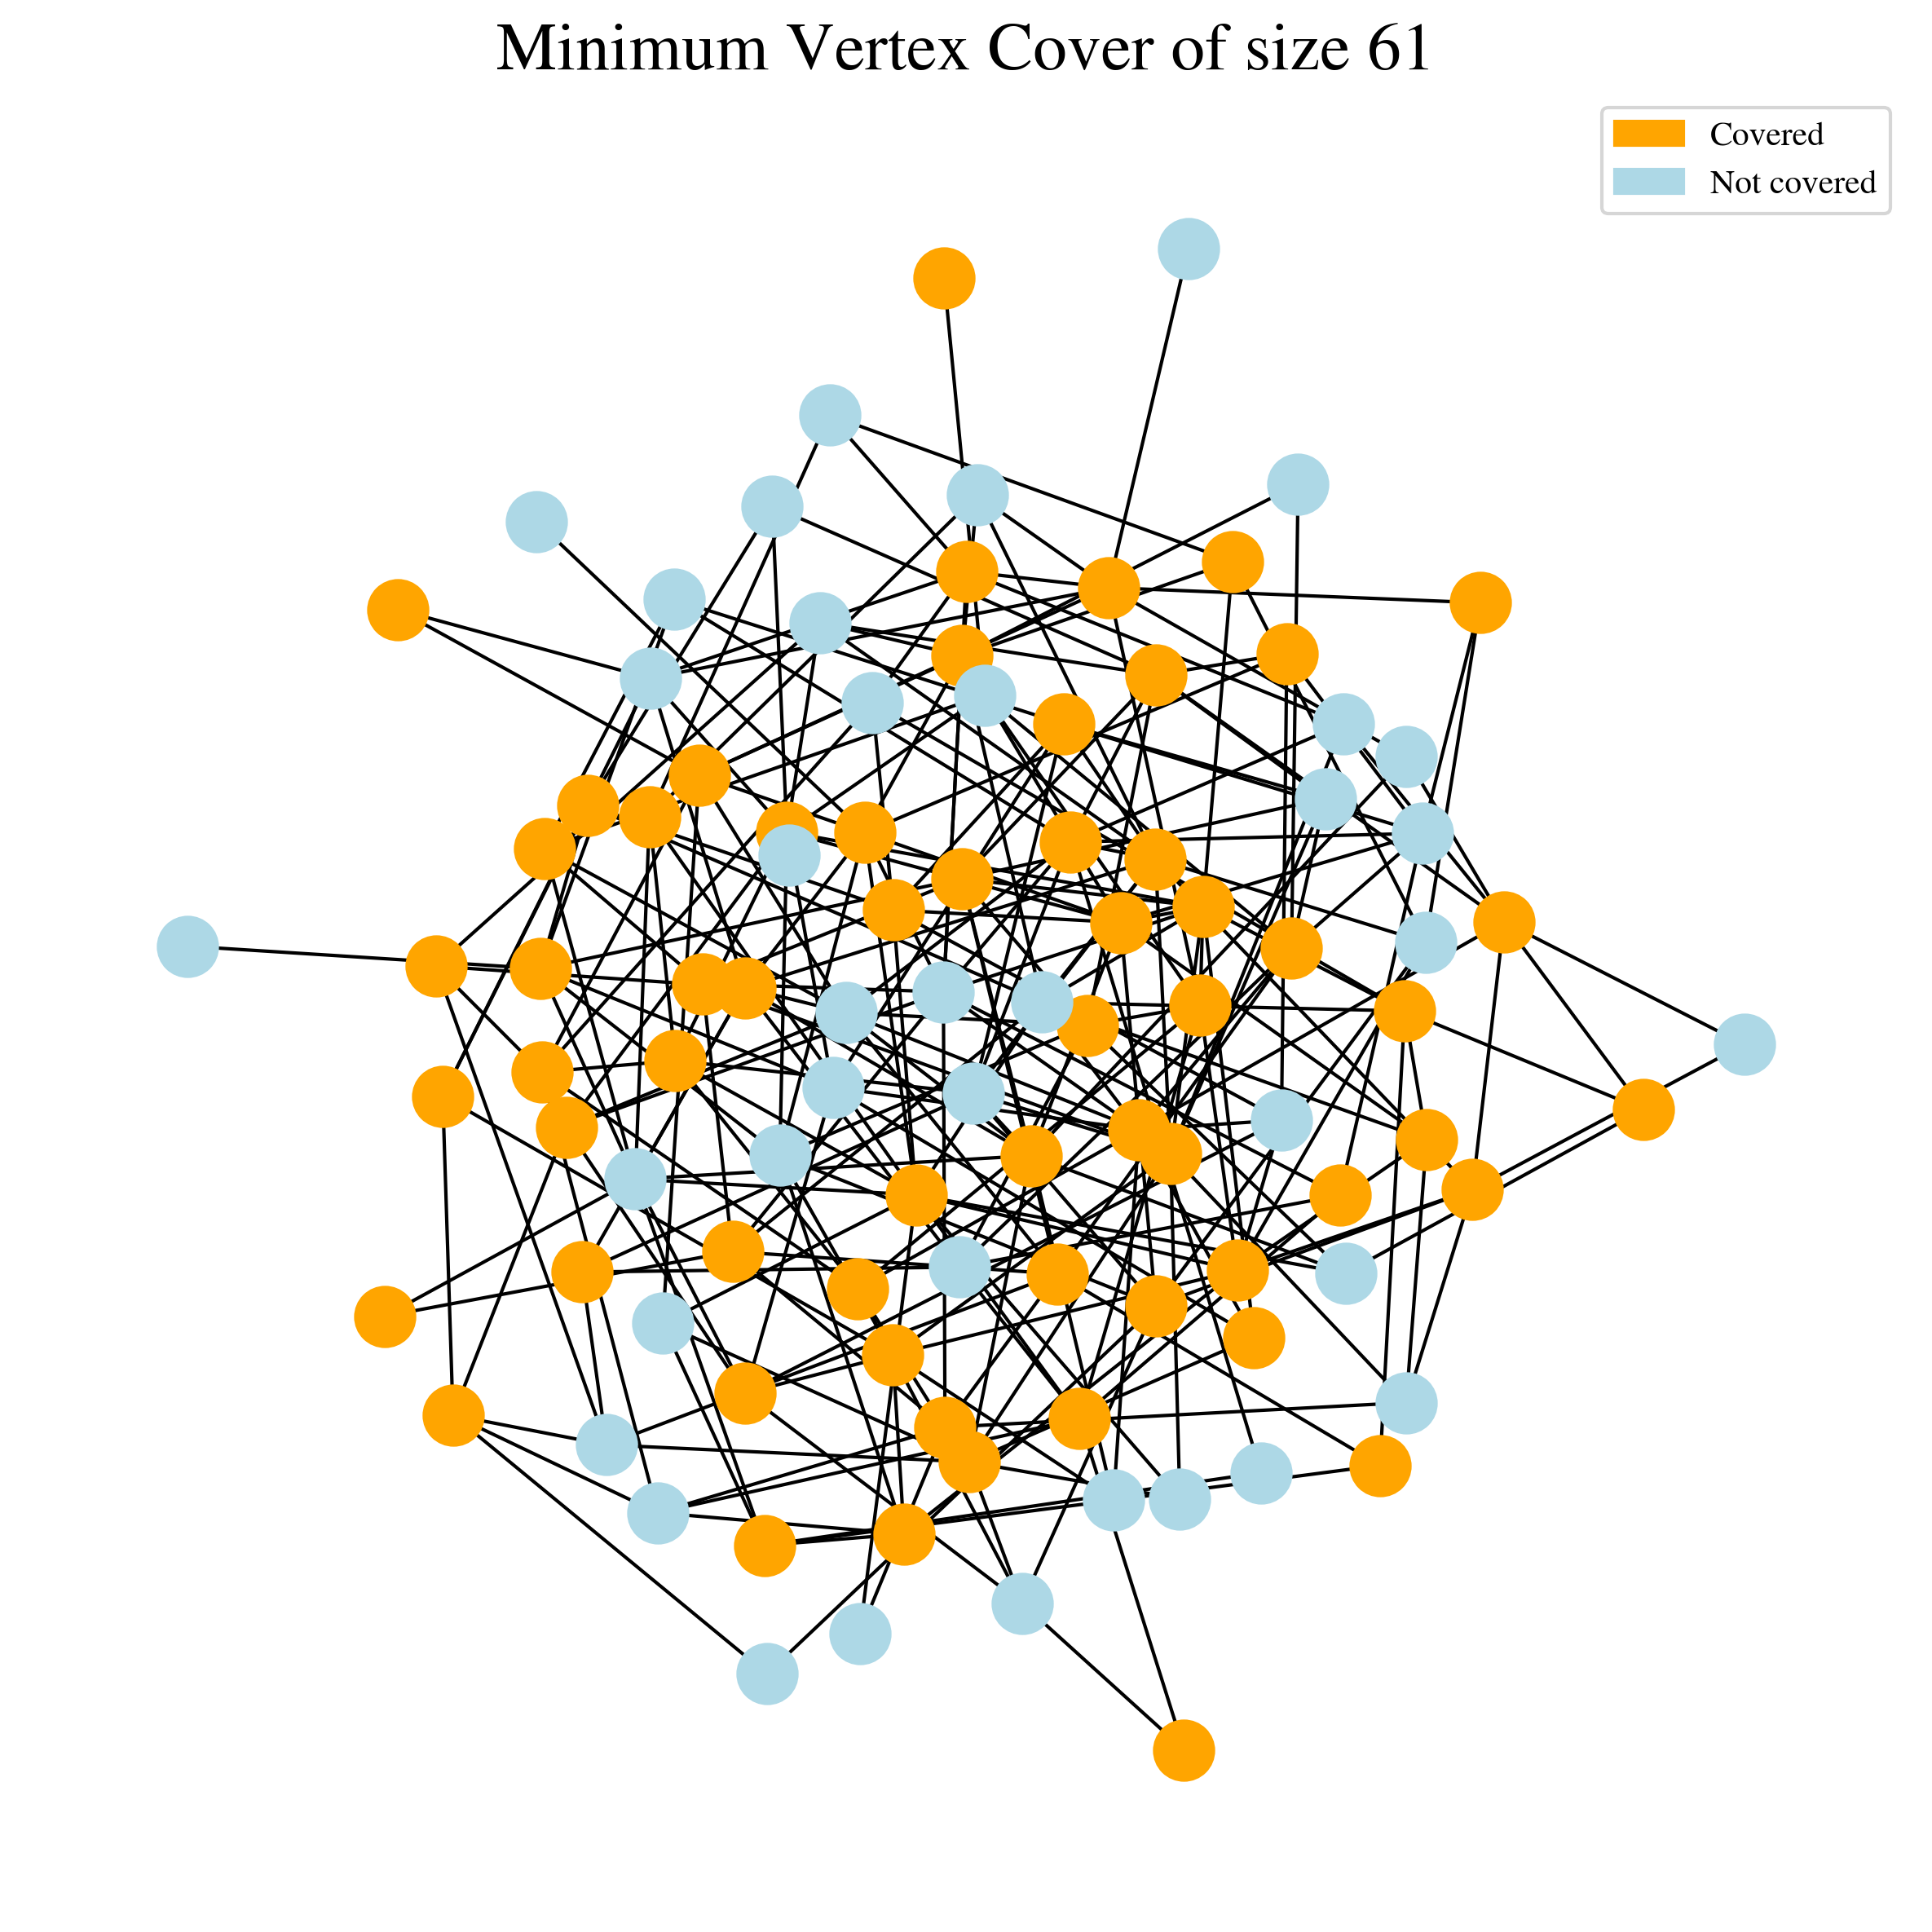

In [5]:
from plot_utils import mvc_plot_graph
from networkx.algorithms.approximation import min_weighted_vertex_cover


def evalute_predicted_cover(
    predicted_nodes: Array, nx_graph: nx.Graph
) -> tuple[int, int]:
    """Count the number of violated edges, and the number
    of covered nodes only connected to other covered nodes.

    Args:
        predicted_nodes (Array): The predicted nodes.
        nx_graph (nx.Graph): The original graph.

    Returns:
        tuple[int, int]: The number of violated edges and unnecessary nodes.
    """
    violations = 0
    for u, v in nx_graph.edges:
        if not (predicted_nodes[u] or predicted_nodes[v]):
            violations += 1

    unnecessary_nodes = 0
    for v in nx_graph.nodes:
        if not predicted_nodes[v]:
            break
        for u in nx_graph.neighbors(v):
            if not predicted_nodes[u]:
                break
        else:
            unnecessary_nodes += 1

    return violations, unnecessary_nodes


predicted_graph = state.apply_fn(state.params, jraph_graph, training=False)
predicted_nodes = predicted_graph.nodes > 0.5

violations, unnecessary = evalute_predicted_cover(predicted_nodes, nx_graph)
approximate = min_weighted_vertex_cover(nx_graph)

print(f"Violations: {violations}")
print(f"Unnecessary nodes: {unnecessary}")
print(f"Approximate cover: {len(approximate)}")
mvc_plot_graph(nx_graph, pos, predicted_nodes > 0.5, savename="mvc_graph_single")

# Varying the starting seed of the model
Here, I keep the same parameters for the GNN, but vary the seed used to initialize the model. This gives us an idea of how sensitive the model is to starting conditions.

In [6]:
import pandas as pd
import numpy as onp
from tqdm.auto import tqdm


def run_model_by_seed(
    random_seed: int, jraph_graph: jraph.GraphsTuple, nx_graph: nx.Graph
) -> tuple[int, int]:
    optimizer = optax.adam(learning_rate=lr)

    net = GCN(
        hidden_size,
        n_class,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        output_activation=nn.sigmoid,
        num_convolutions=num_convolutions,
    )

    state, _, _ = train(
        jraph_graph,
        net,
        optimizer,
        n_epochs,
        tol=0.01,
        patience=250,
        warm_up=100,
        random_seed=random_seed,
        show_progress=False,
    )

    predicted_graph = state.apply_fn(state.params, jraph_graph, training=False)
    predicted_nodes = predicted_graph.nodes > 0.5

    violations, unnecessary = evalute_predicted_cover(predicted_nodes, nx_graph)
    size = predicted_nodes.sum()

    return violations, unnecessary, size


number_of_seeds = 100
results = onp.zeros((number_of_seeds, 3))
for i in tqdm(range(number_of_seeds)):
    results[i] = run_model_by_seed(i, jraph_graph, nx_graph)

  0%|          | 0/100 [00:00<?, ?it/s]

The results do not provide an interesting plot, so we stick with just a count of the occurances. As we can tell, the model is pretty stable.

In [7]:
df = pd.DataFrame(results, columns=["violations", "unnecessary", "size"])

df.value_counts()

violations  unnecessary  size
0.0         0.0          61.0    69
                         60.0    19
                         62.0     9
                         59.0     1
            1.0          62.0     1
            38.0         99.0     1
Name: count, dtype: int64

## Training the model on a larger set of graphs

In [8]:
n_graphs = 100
# n_graphs = 5
n_nodes = 100
# n_nodes = 10
p = 0.05
d = 3
# p = 1

training_random_graphs = [
    generate_graph(n_nodes, prob=p, graph_type="erdos", random_seed=i)
    for i in range(0, n_graphs)
]
training_regular_graphs = [
    generate_graph(n_nodes, degree=d, graph_type="reg", random_seed=i)
    for i in range(0, n_graphs)
]

validation_random_graphs = [
    generate_graph(n_nodes, prob=p, graph_type="erdos", random_seed=i)
    for i in range(2024, 2024 + n_graphs)
]
validation_regular_graphs = [
    generate_graph(n_nodes, degree=3, graph_type="reg", random_seed=i)
    for i in range(2024, 2024 + n_graphs)
]

In [24]:
from networkx.algorithms.approximation import min_weighted_vertex_cover
from pandas.core.frame import DataFrame


def predict_graphs(
    graphs: list[nx.Graph], state: TrainState
) -> tuple[ArrayLike, ArrayLike]:
    n_graphs = len(graphs)
    results = onp.zeros((n_graphs, 3))
    approx = onp.zeros((n_graphs, 1))

    for i, (nx_graph, pos) in enumerate(graphs):
        jraph_graph = graph_to_jraph(nx_graph, pos)
        predicted_graph = state.apply_fn(state.params, jraph_graph, training=False)
        predicted_nodes = predicted_graph.nodes > 0.5

        violations, unnecessary = evalute_predicted_cover(predicted_nodes, nx_graph)
        size = predicted_nodes.sum()
        # print(violations, unnecessary, size)
        results[i] = violations, size, unnecessary
        approx[i] = len(min_weighted_vertex_cover(nx_graph))

    return results, approx


def train_model(
    training_graphs: list[tuple[nx.Graph, dict]],
    n_epochs: int,
    learning_rate: float,
    hidden_size: int,
    n_class: int,
    num_layers: int,
    num_convolutions: int,
    dropout_rate: float,
    tol: float = 0.0001,
    patience: int = 250,
) -> TrainState:
    training_jraph_graphs = [
        graph_to_jraph(nx_graph, pos) for nx_graph, pos in training_graphs
    ]

    training_batched_graphs = jraph.batch(training_jraph_graphs)

    optimizer = optax.adam(learning_rate=learning_rate)

    net = GCN(
        hidden_size,
        n_class,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        output_activation=nn.sigmoid,
        num_convolutions=num_convolutions,
    )

    state, _, _ = train(
        training_batched_graphs,
        net,
        optimizer,
        n_epochs,
        tol=tol,
        patience=patience,
    )

    return state


def predict_graph_df(graphs: list[nx.Graph], state: TrainState) -> DataFrame:
    results, approx = predict_graphs(graphs, state)

    columns = ["violated edges", "size of cover", "unneccesary nodes", "approximation"]

    df = pd.DataFrame(results, columns=columns[:-1])
    df[columns[-1]] = approx

    return df

In [27]:
hidden_size = 100
n_class = 1
num_layers = 1
num_convolutions = 2
dropout_rate = 0.0

n_epochs = 10000
lr = 0.001

state = train_model(
    training_random_graphs,
    n_epochs,
    learning_rate=lr,
    hidden_size=hidden_size,
    n_class=n_class,
    num_layers=num_layers,
    num_convolutions=num_convolutions,
    dropout_rate=dropout_rate,
    # tol = 0.00001,
    # patience=1000,
)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

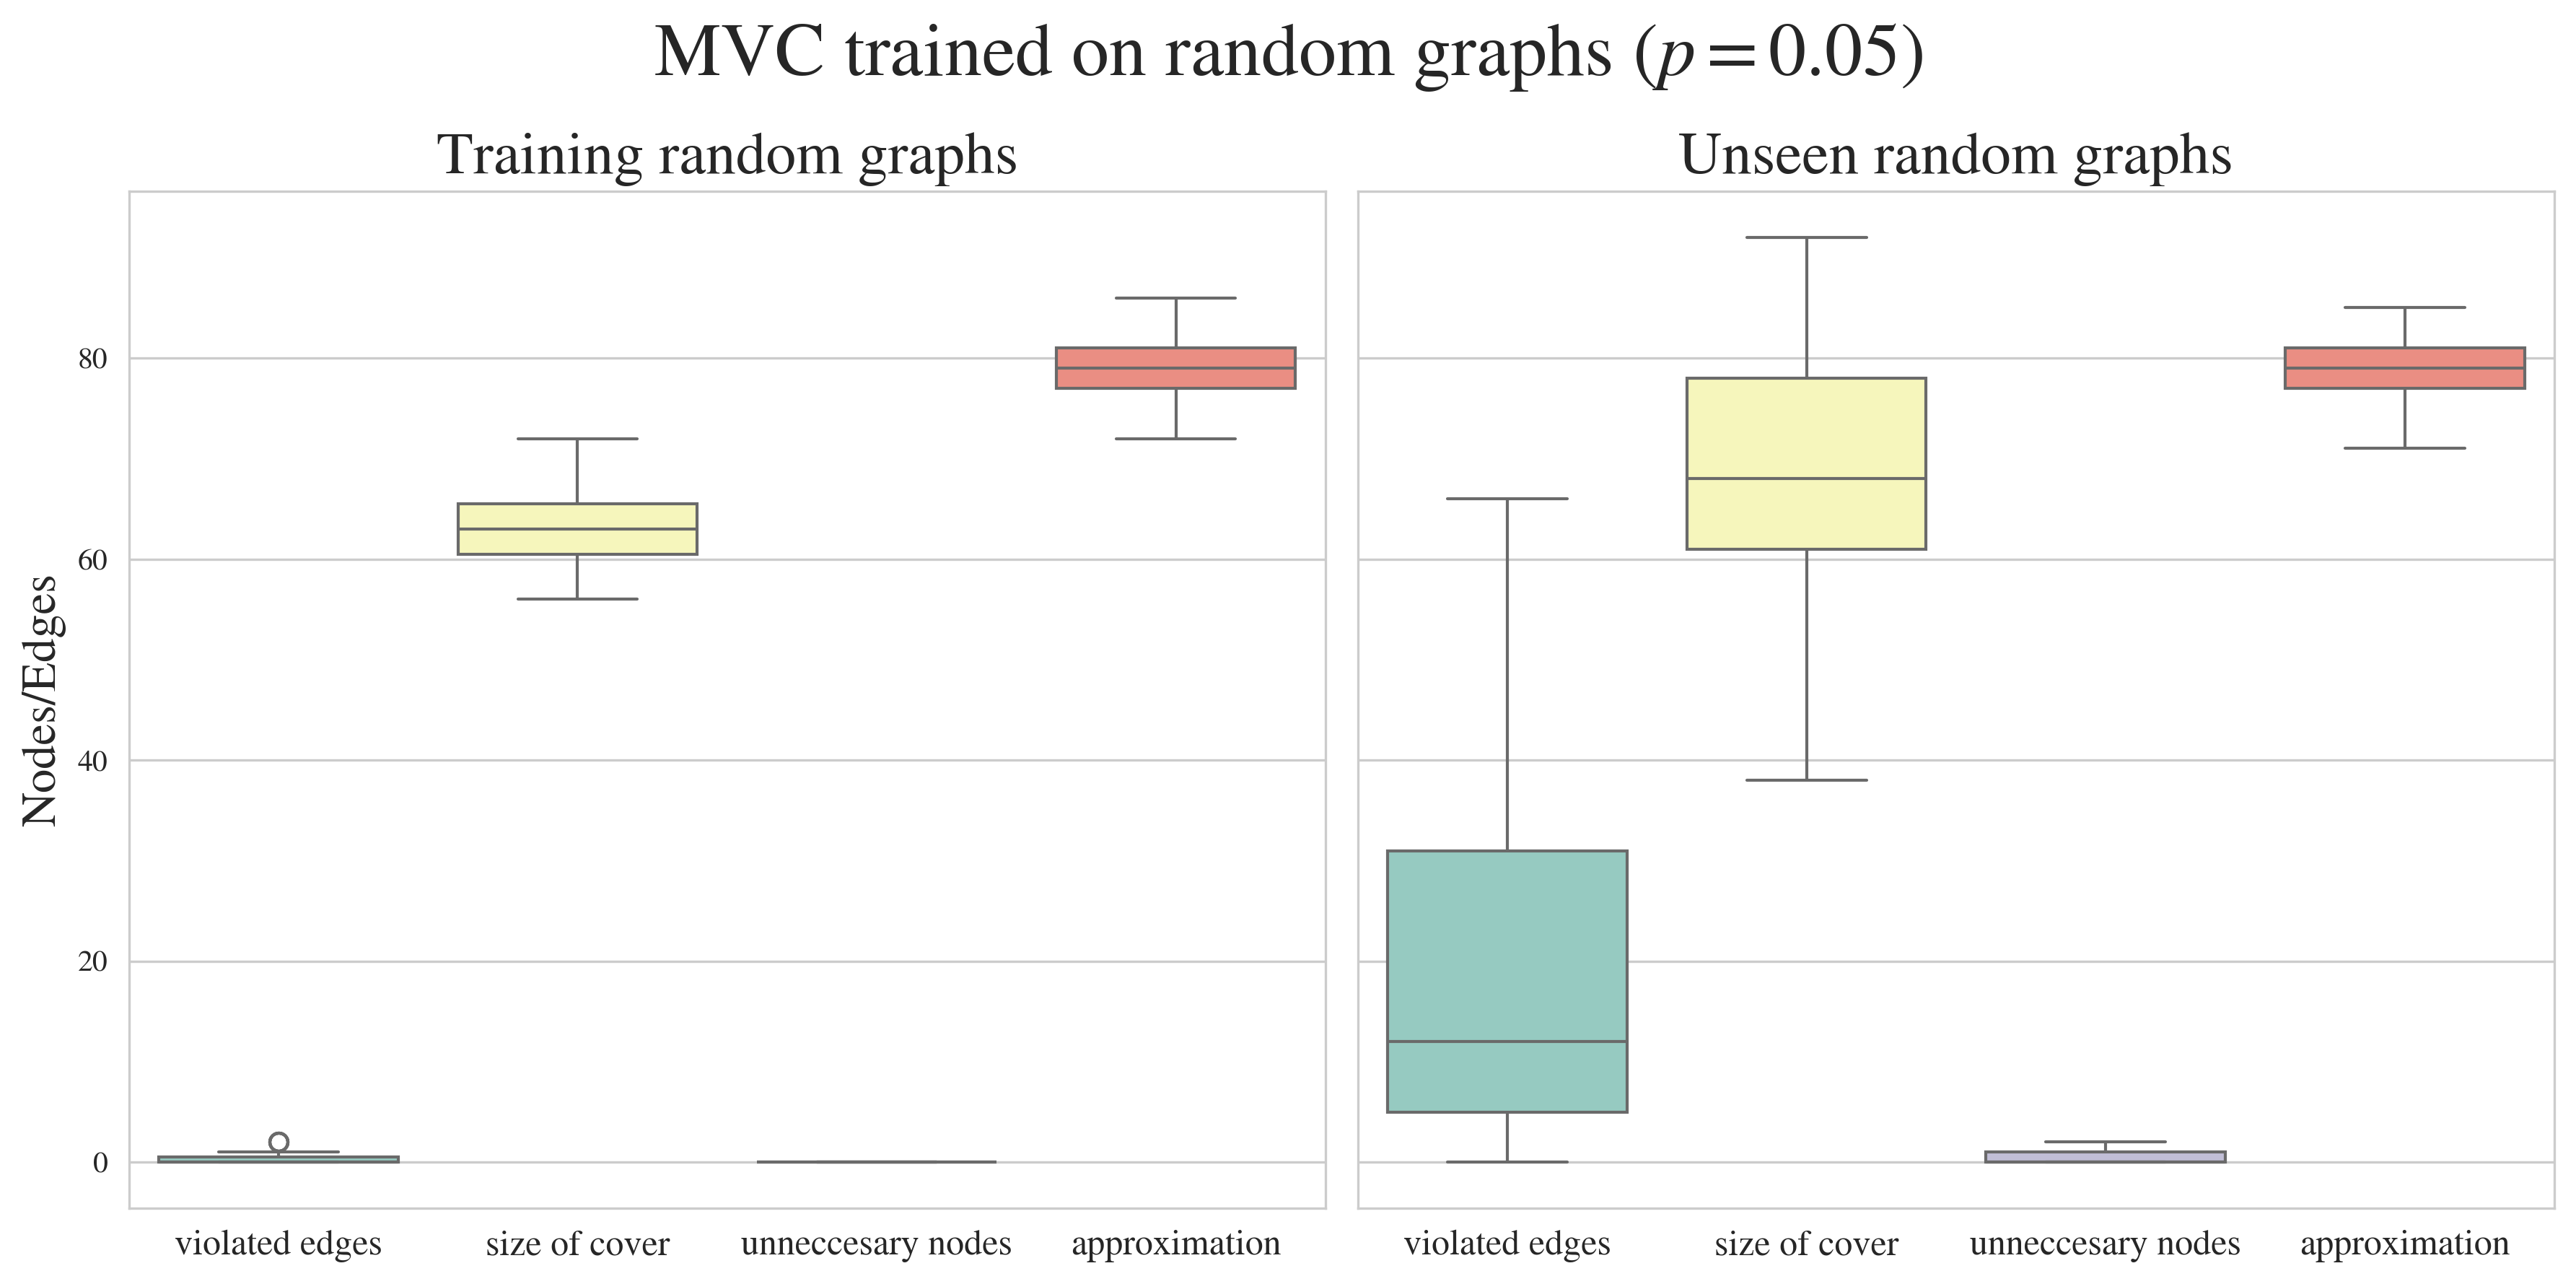

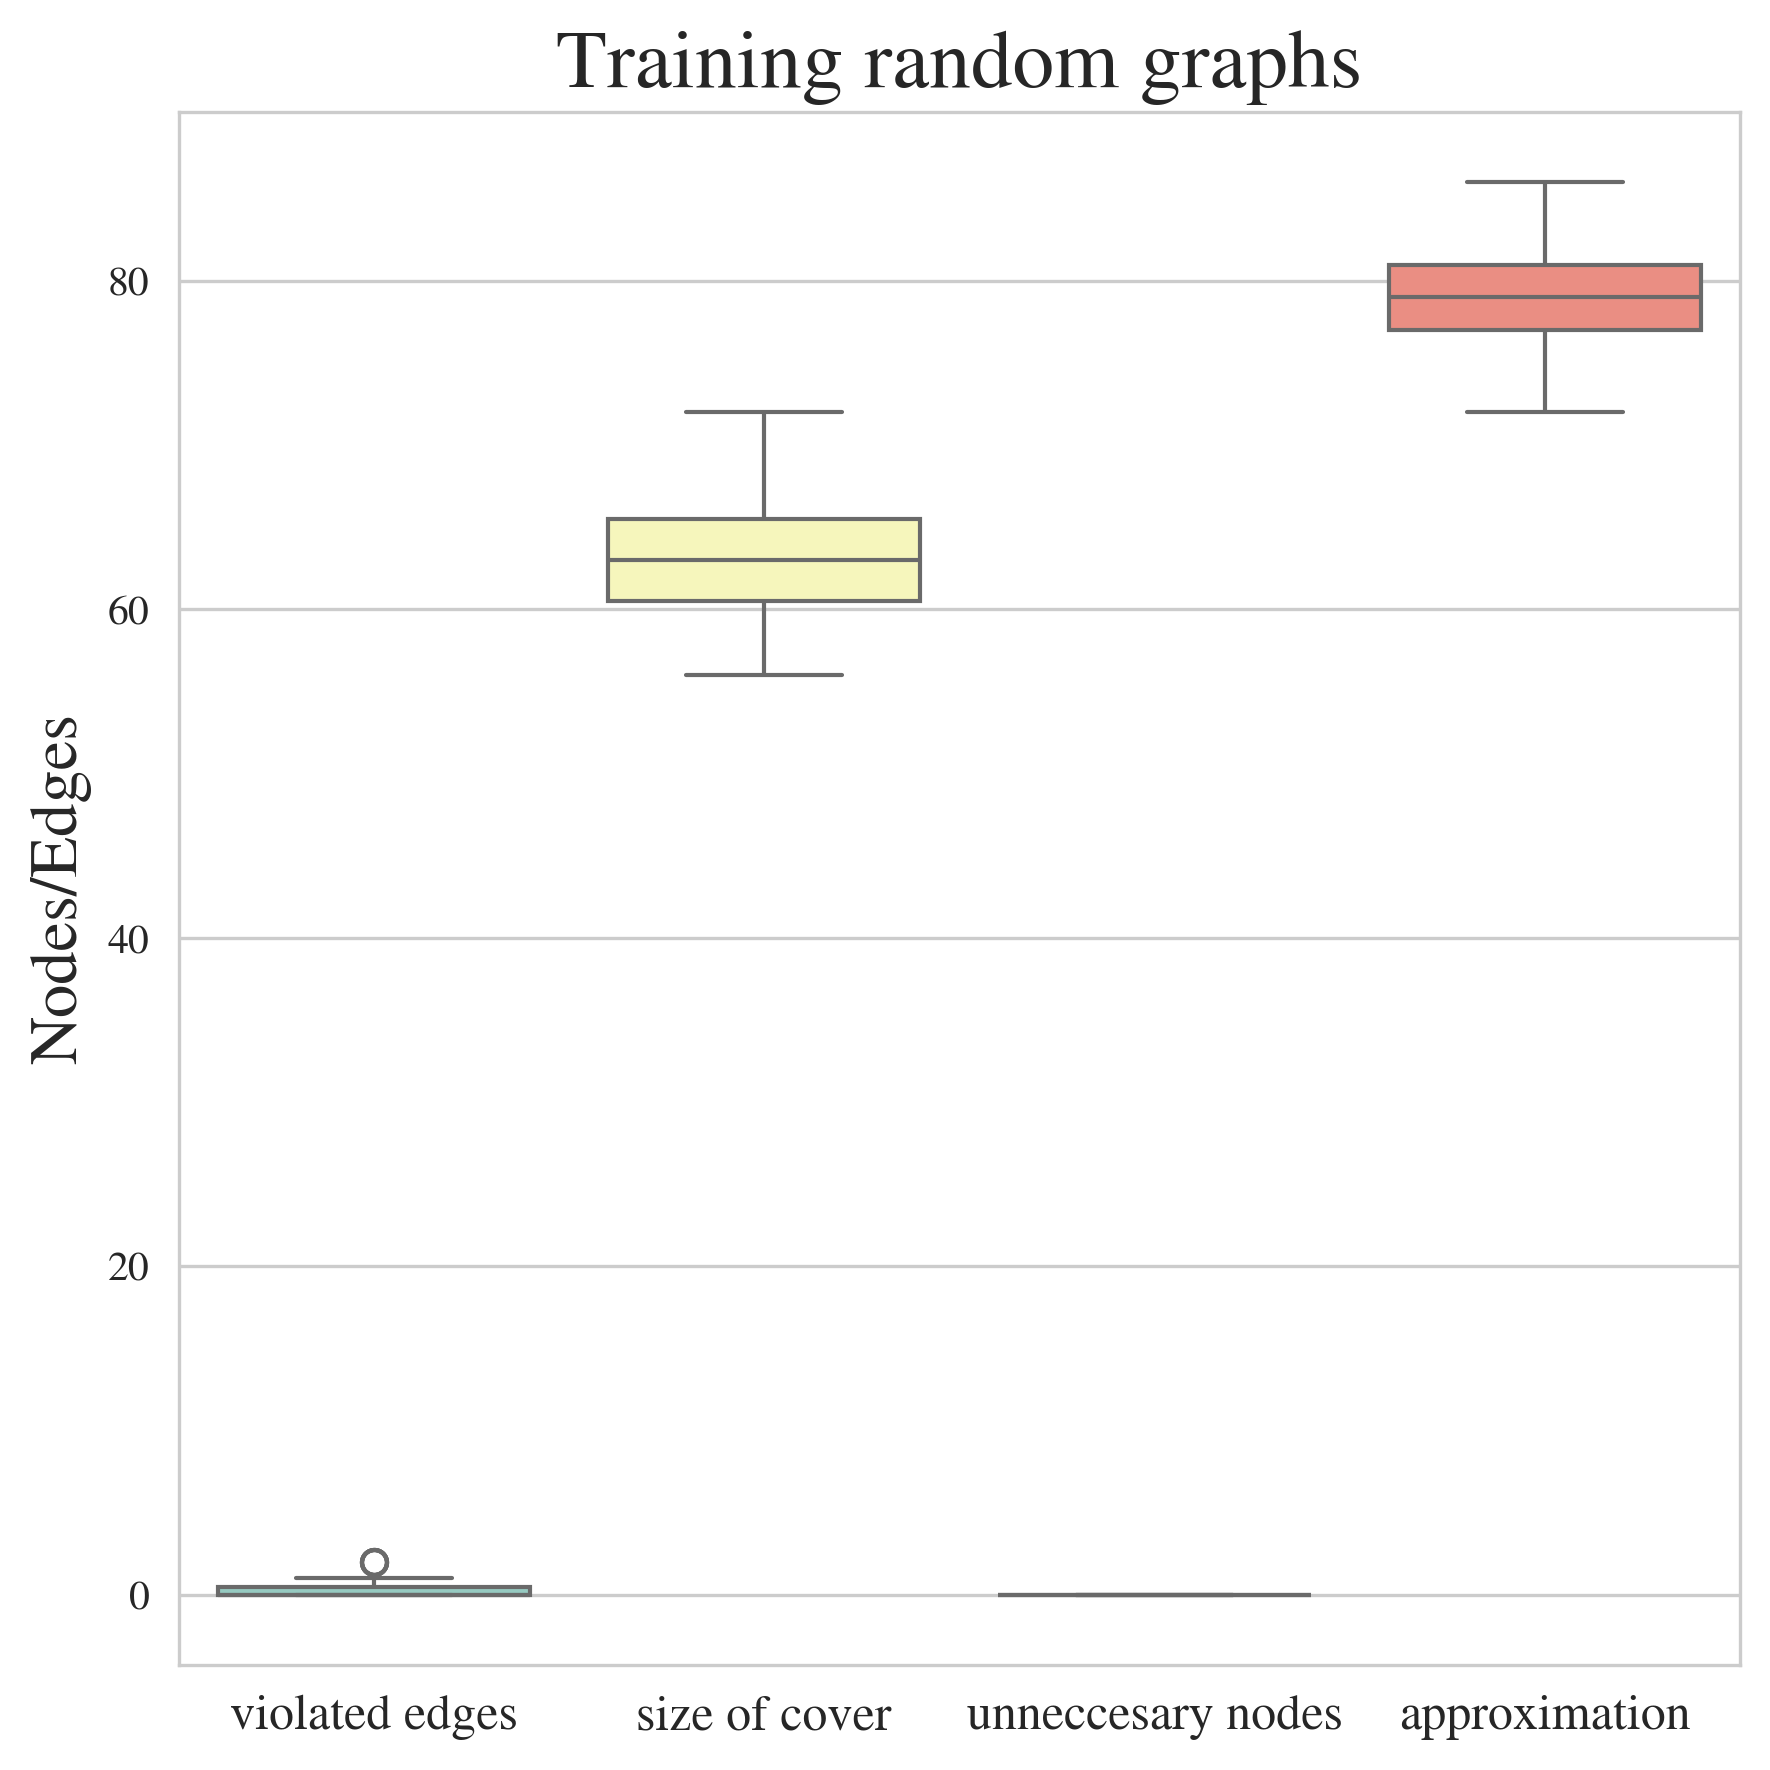

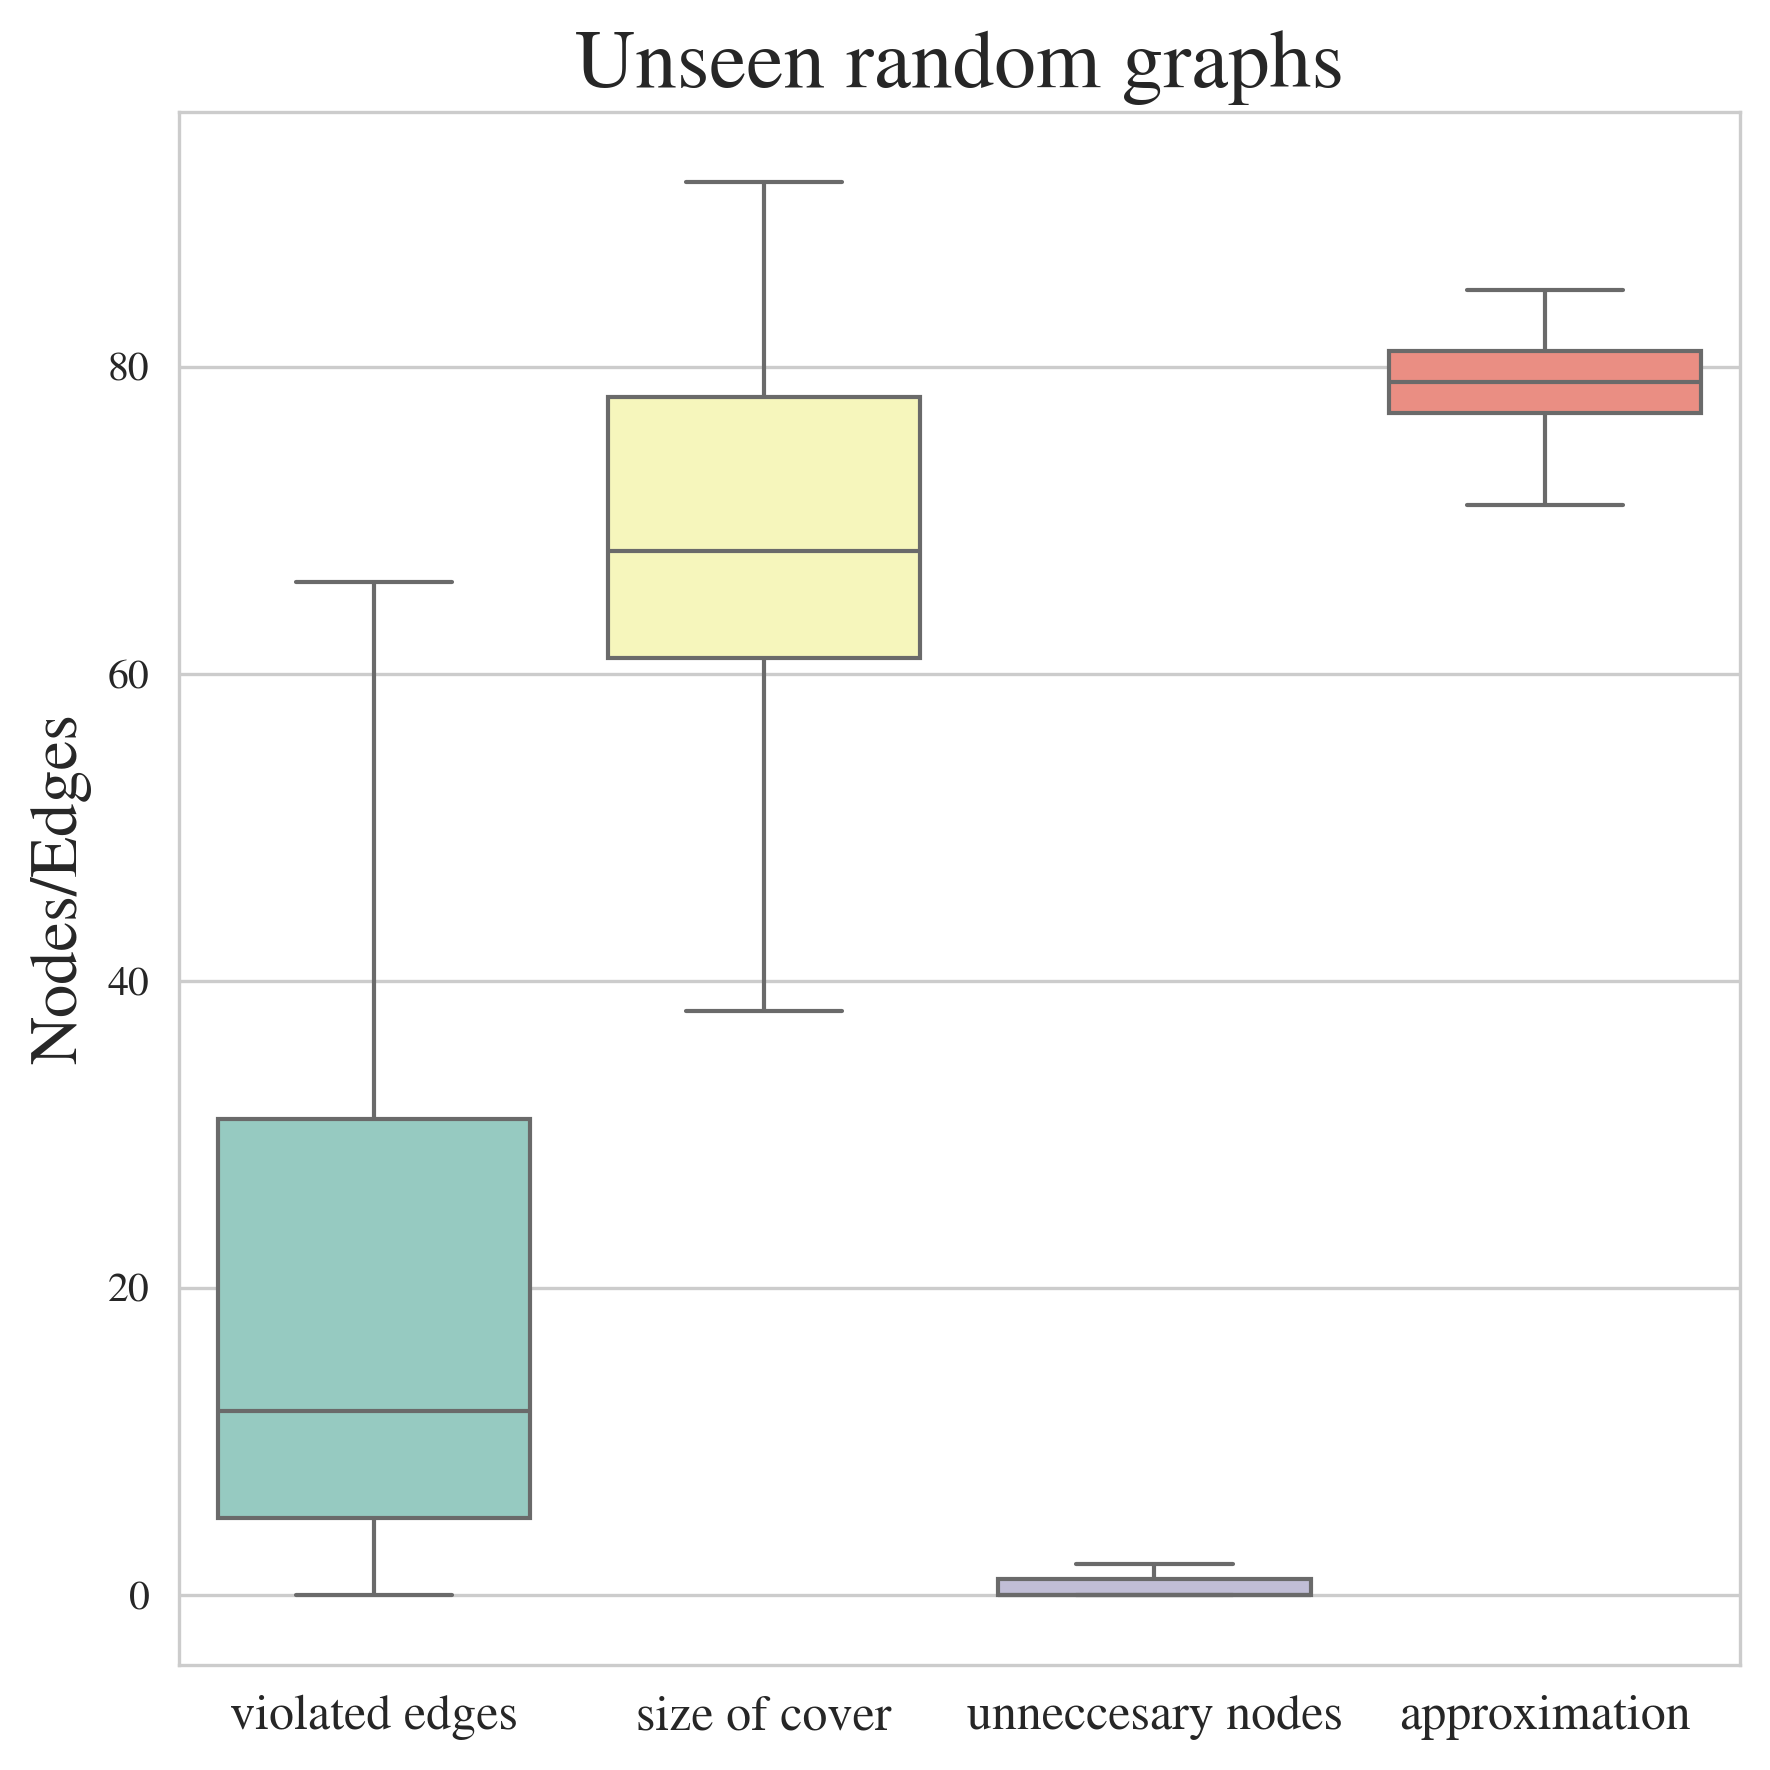

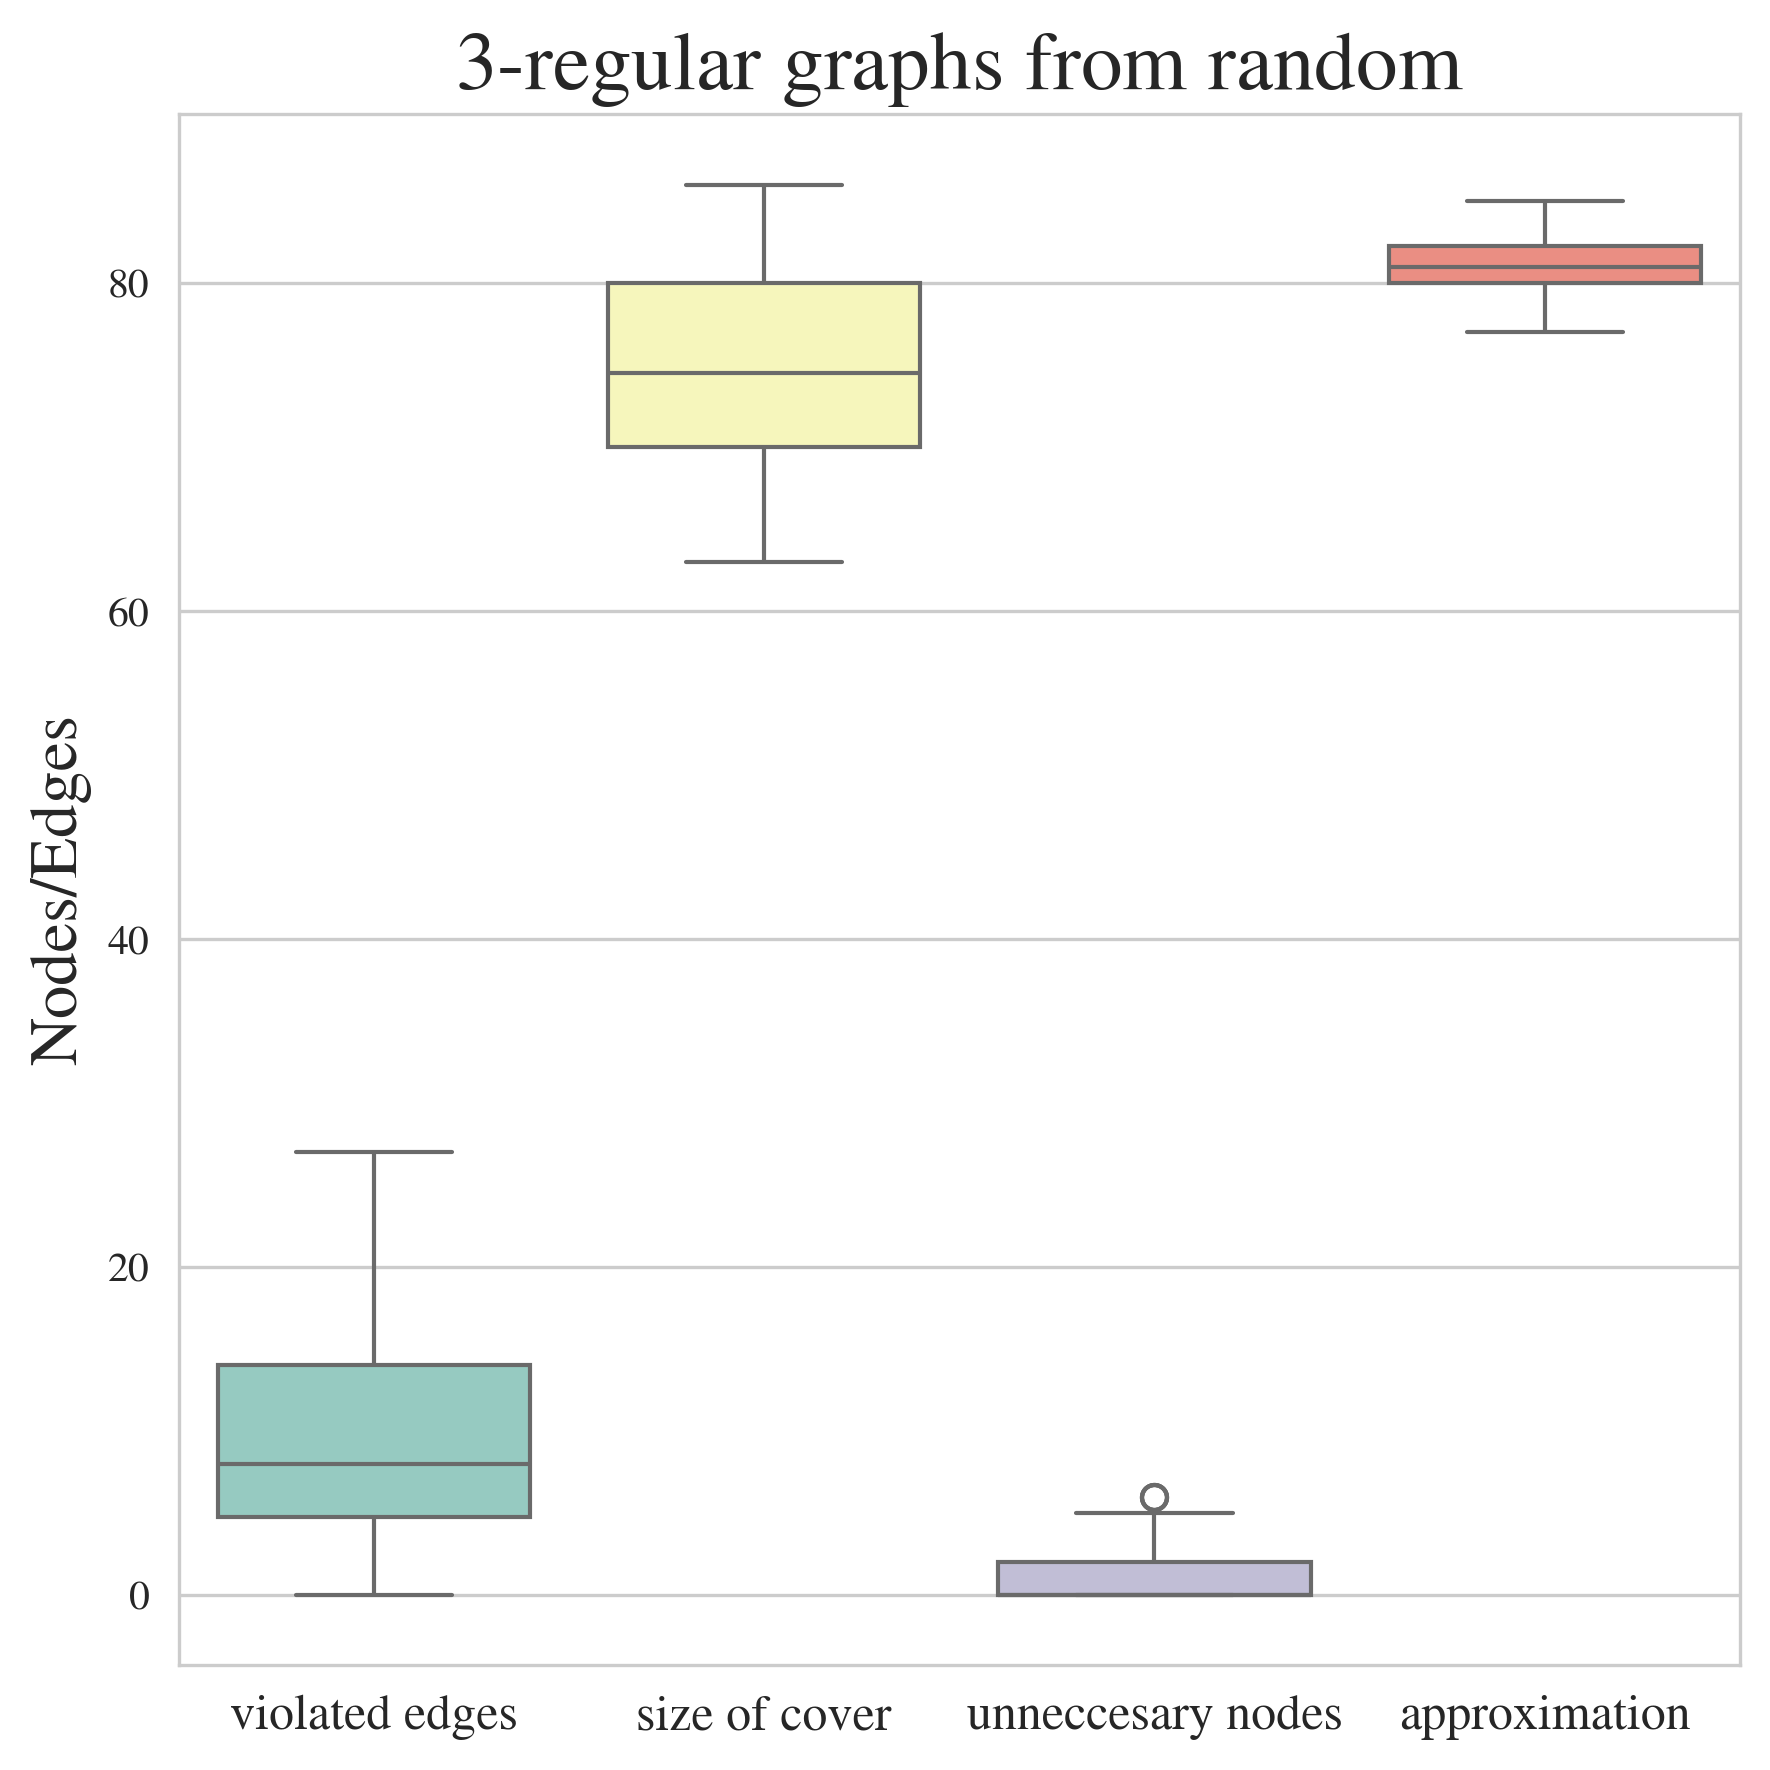

In [28]:
from plot_utils import seen_vs_unseen_mvc_graphs, single_boxplot

df_train_random = predict_graph_df(training_random_graphs, state)
df_val_random = predict_graph_df(validation_random_graphs, state)
df_val_regular = predict_graph_df(validation_regular_graphs, state)

seen_vs_unseen_mvc_graphs(
    [df_train_random, df_val_random],
    ["Training random graphs", "Unseen random graphs"],
    suptitle="MVC trained on random graphs ($p=0.05$)",
    savename="mvc_random_boxes",
)

single_boxplot(
    df_train_random,
    title="Training random graphs",
    savename="mvc_train_random",
)

single_boxplot(
    df_val_random,
    title="Unseen random graphs",
    savename="mvc_random_to_random",
)

single_boxplot(
    df_val_regular,
    title="$3$-regular graphs from random",
    savename="mvc_random_to_regular",
)

In [20]:
reg_state = train_model(
    training_regular_graphs,
    n_epochs,
    learning_rate=lr,
    hidden_size=hidden_size,
    n_class=n_class,
    num_layers=num_layers,
    num_convolutions=num_convolutions,
    dropout_rate=dropout_rate,
)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Early stopping at epoch 2584


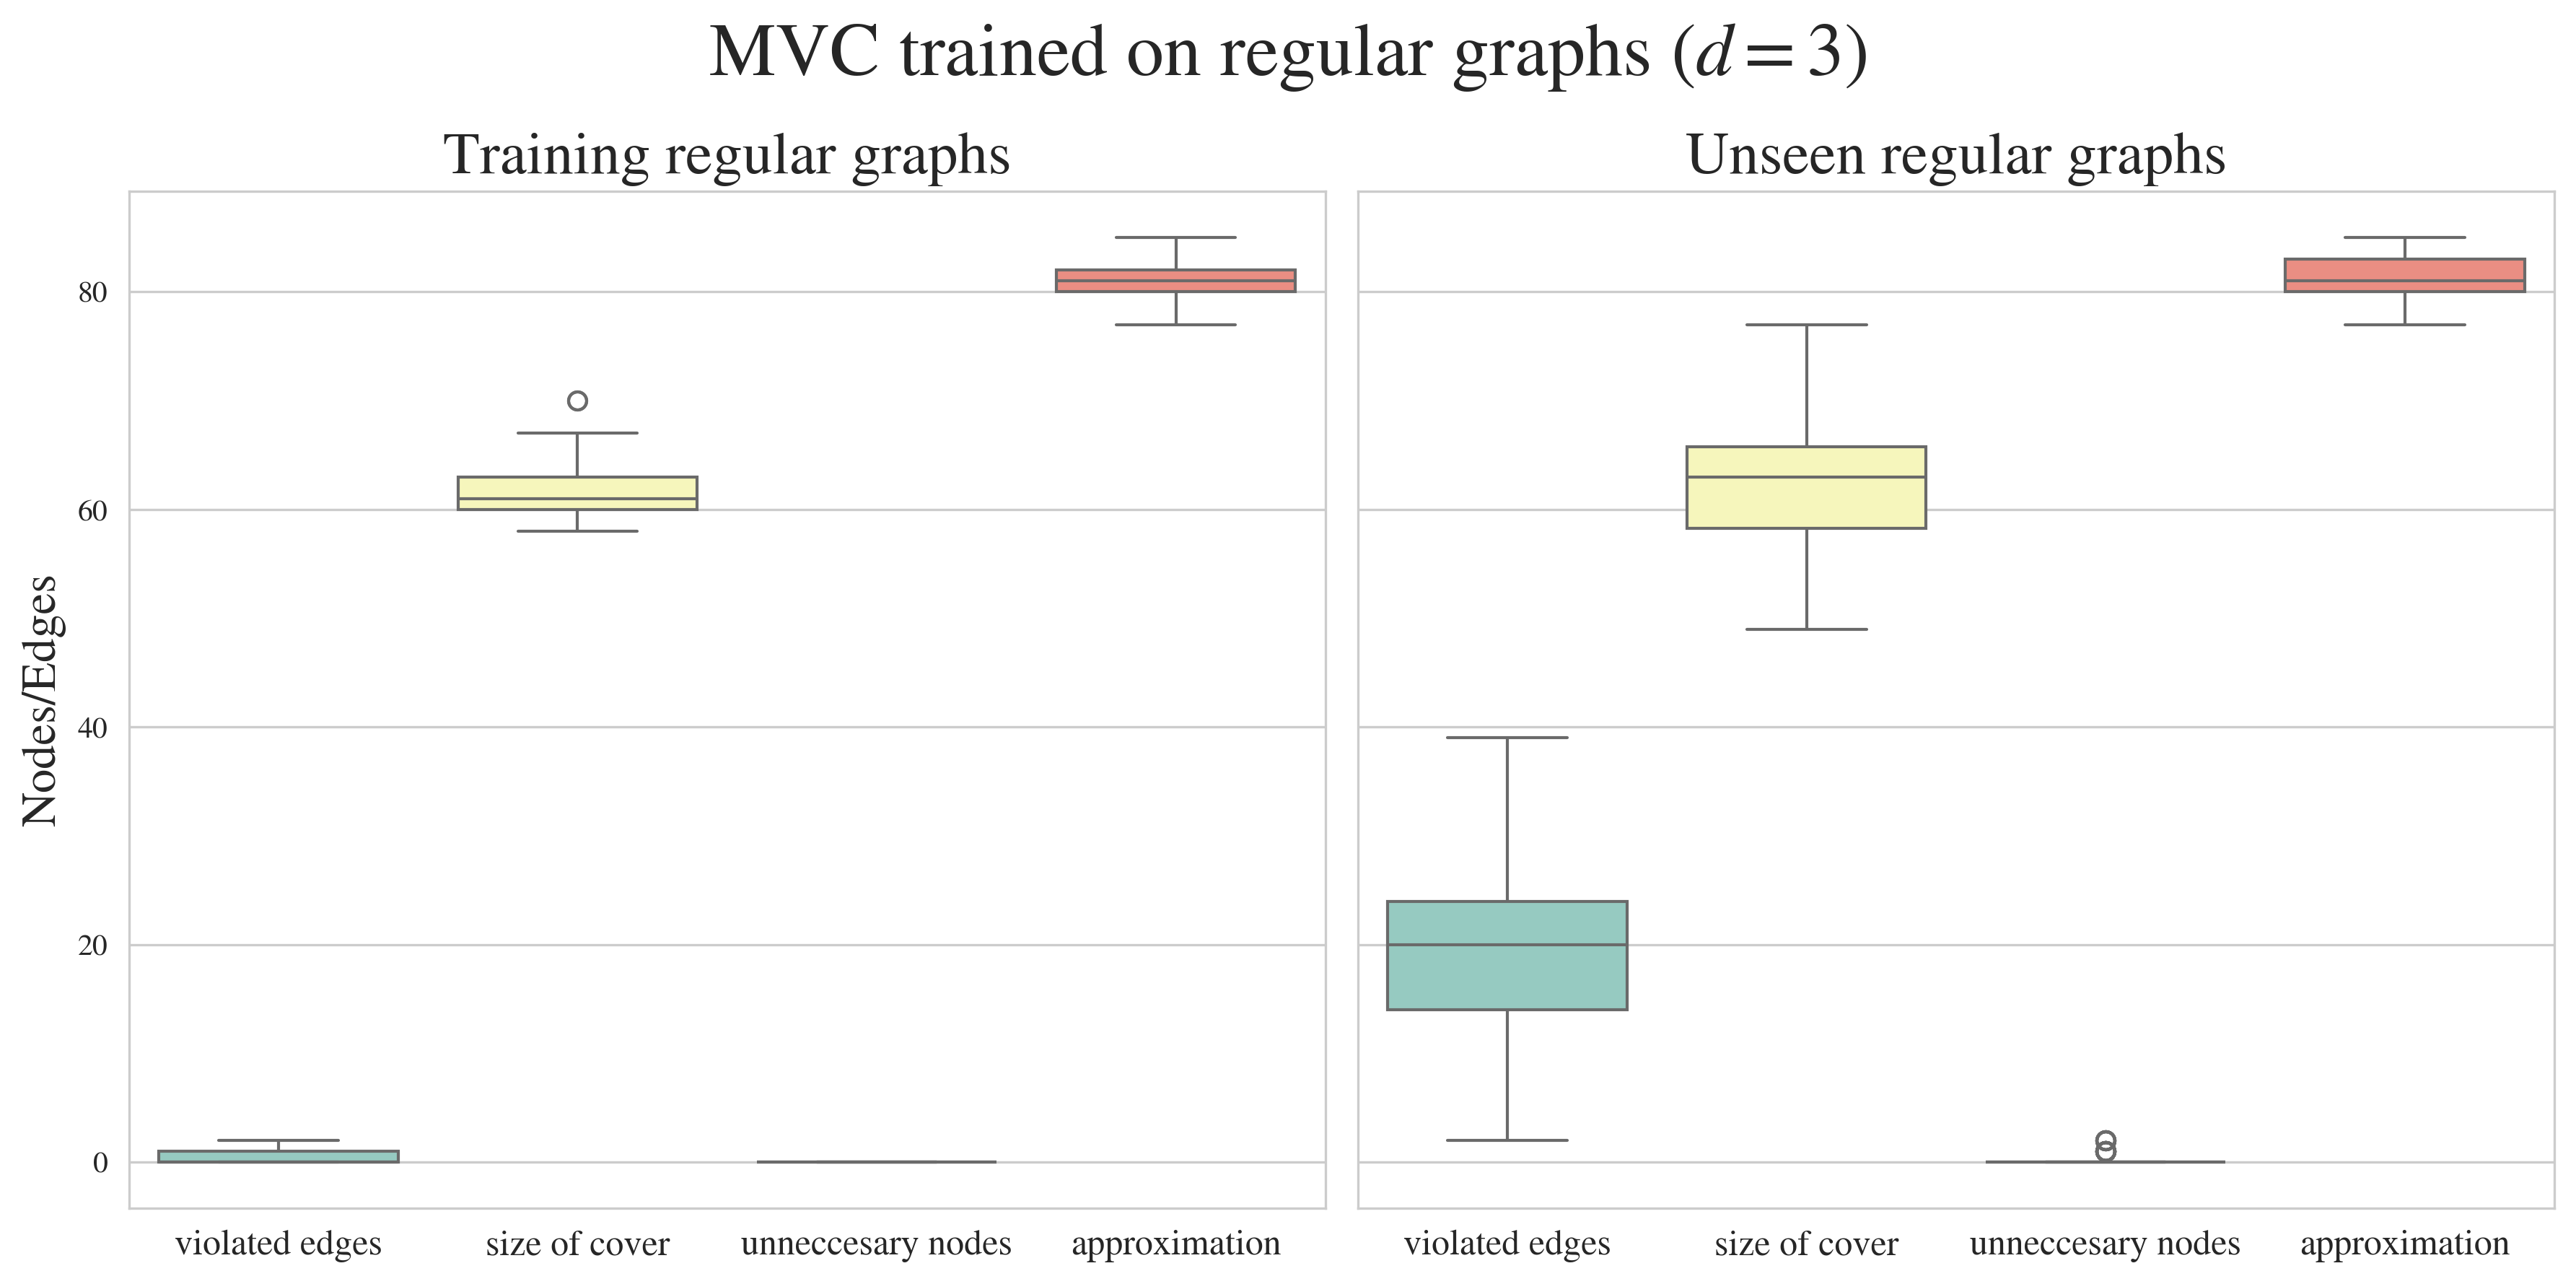

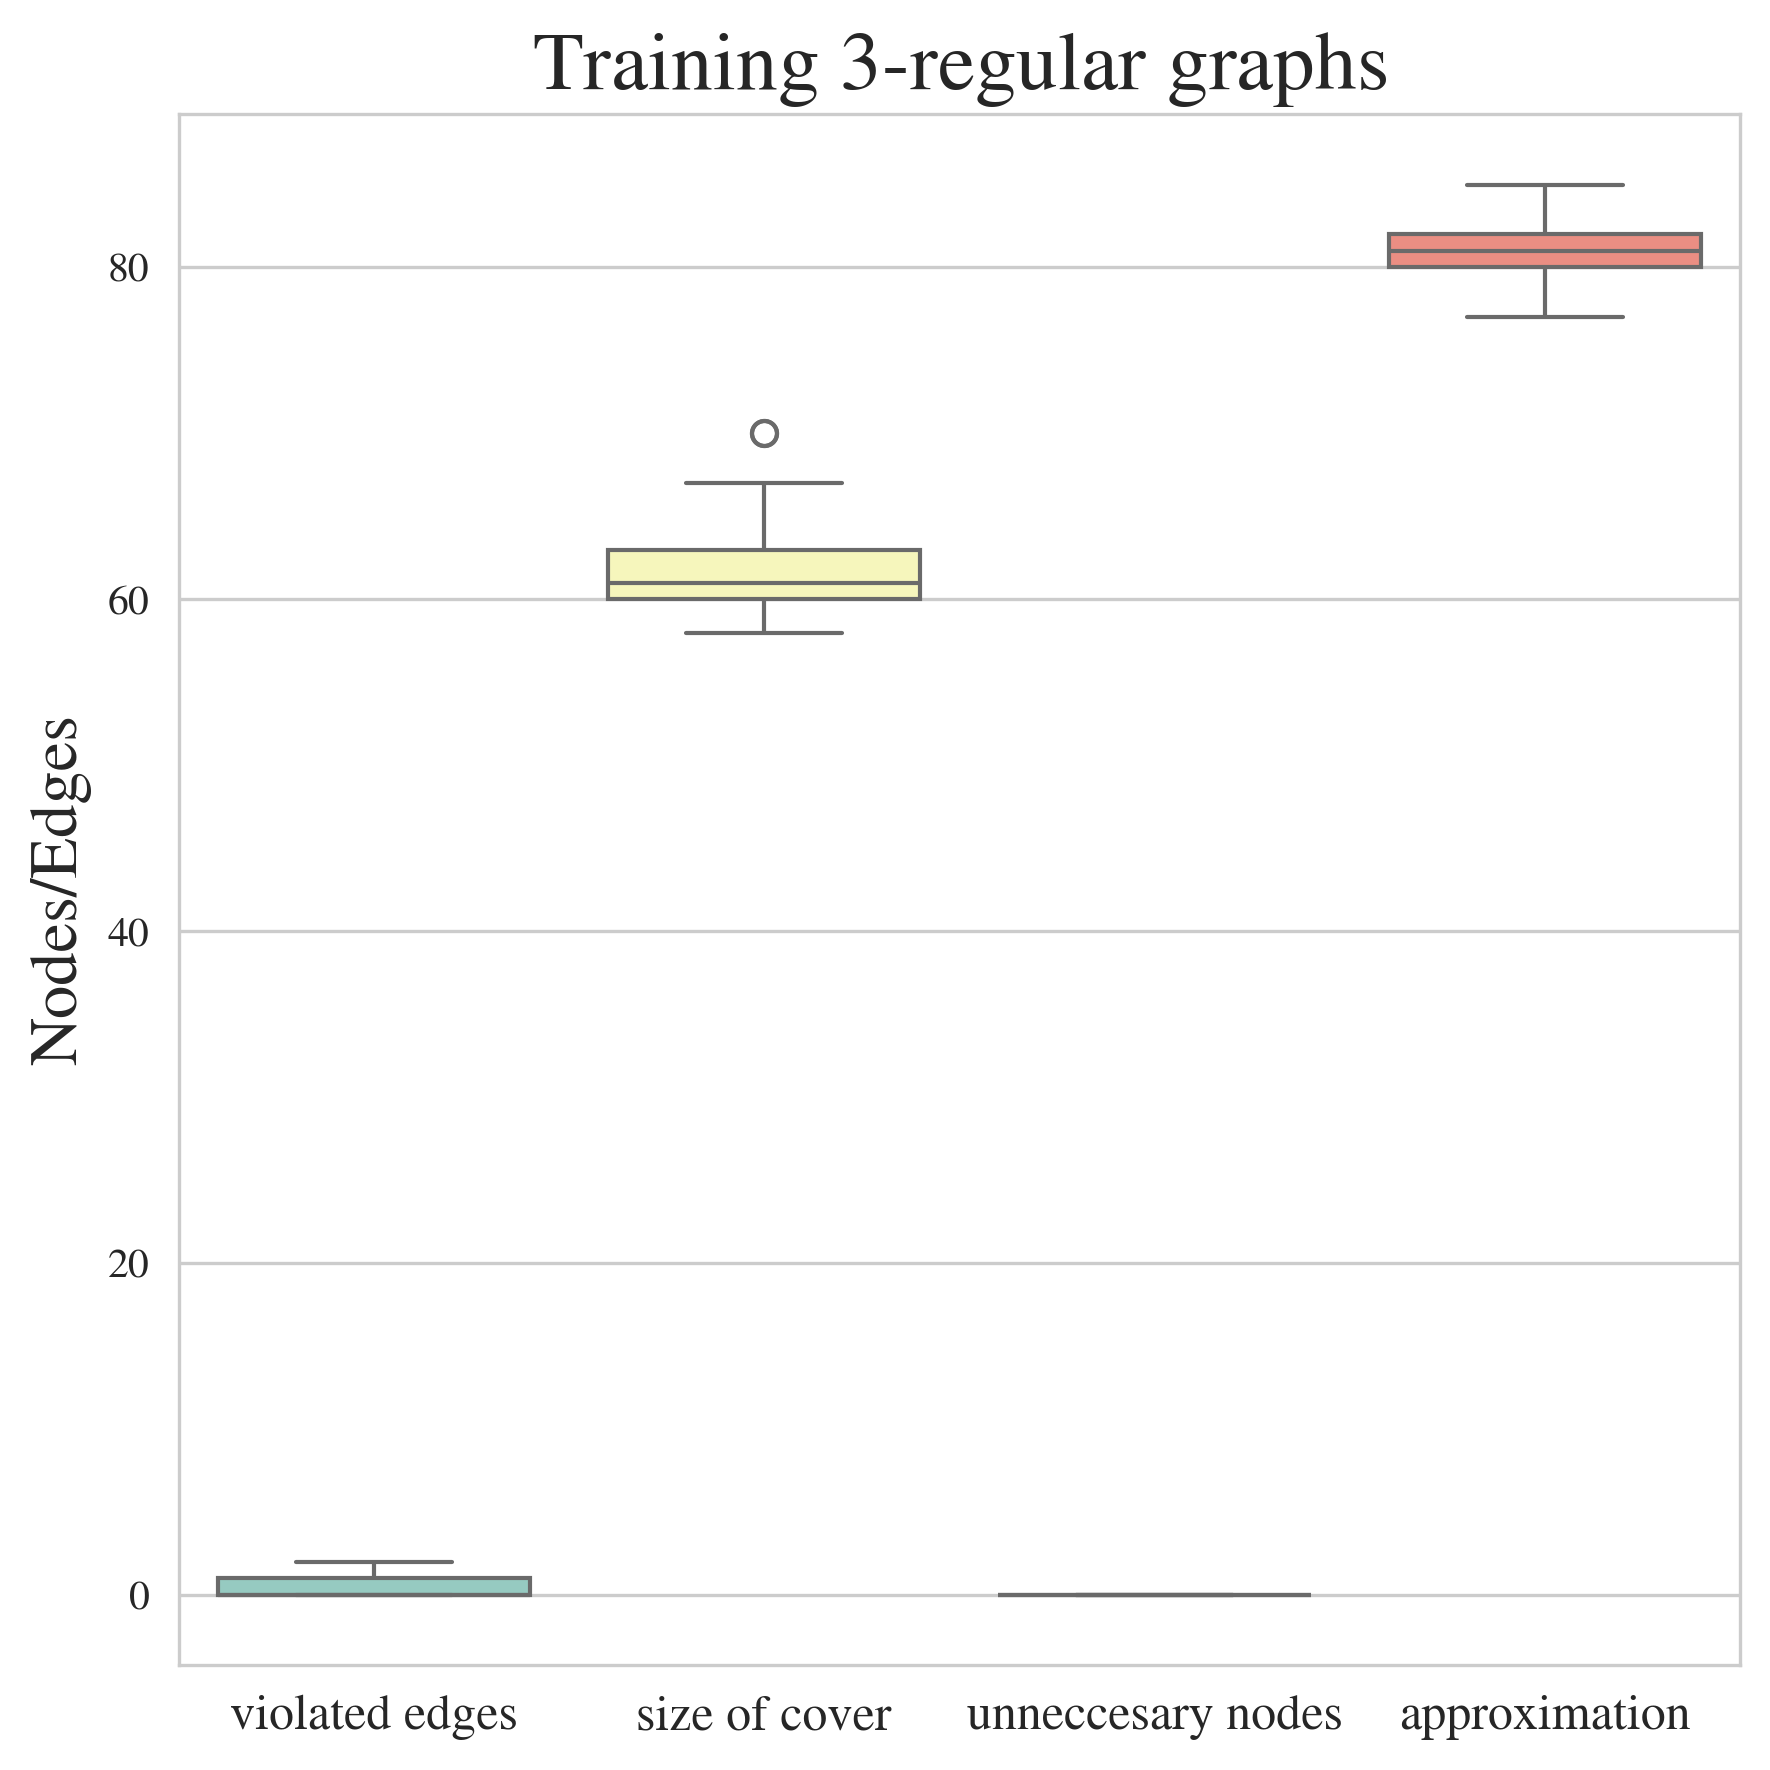

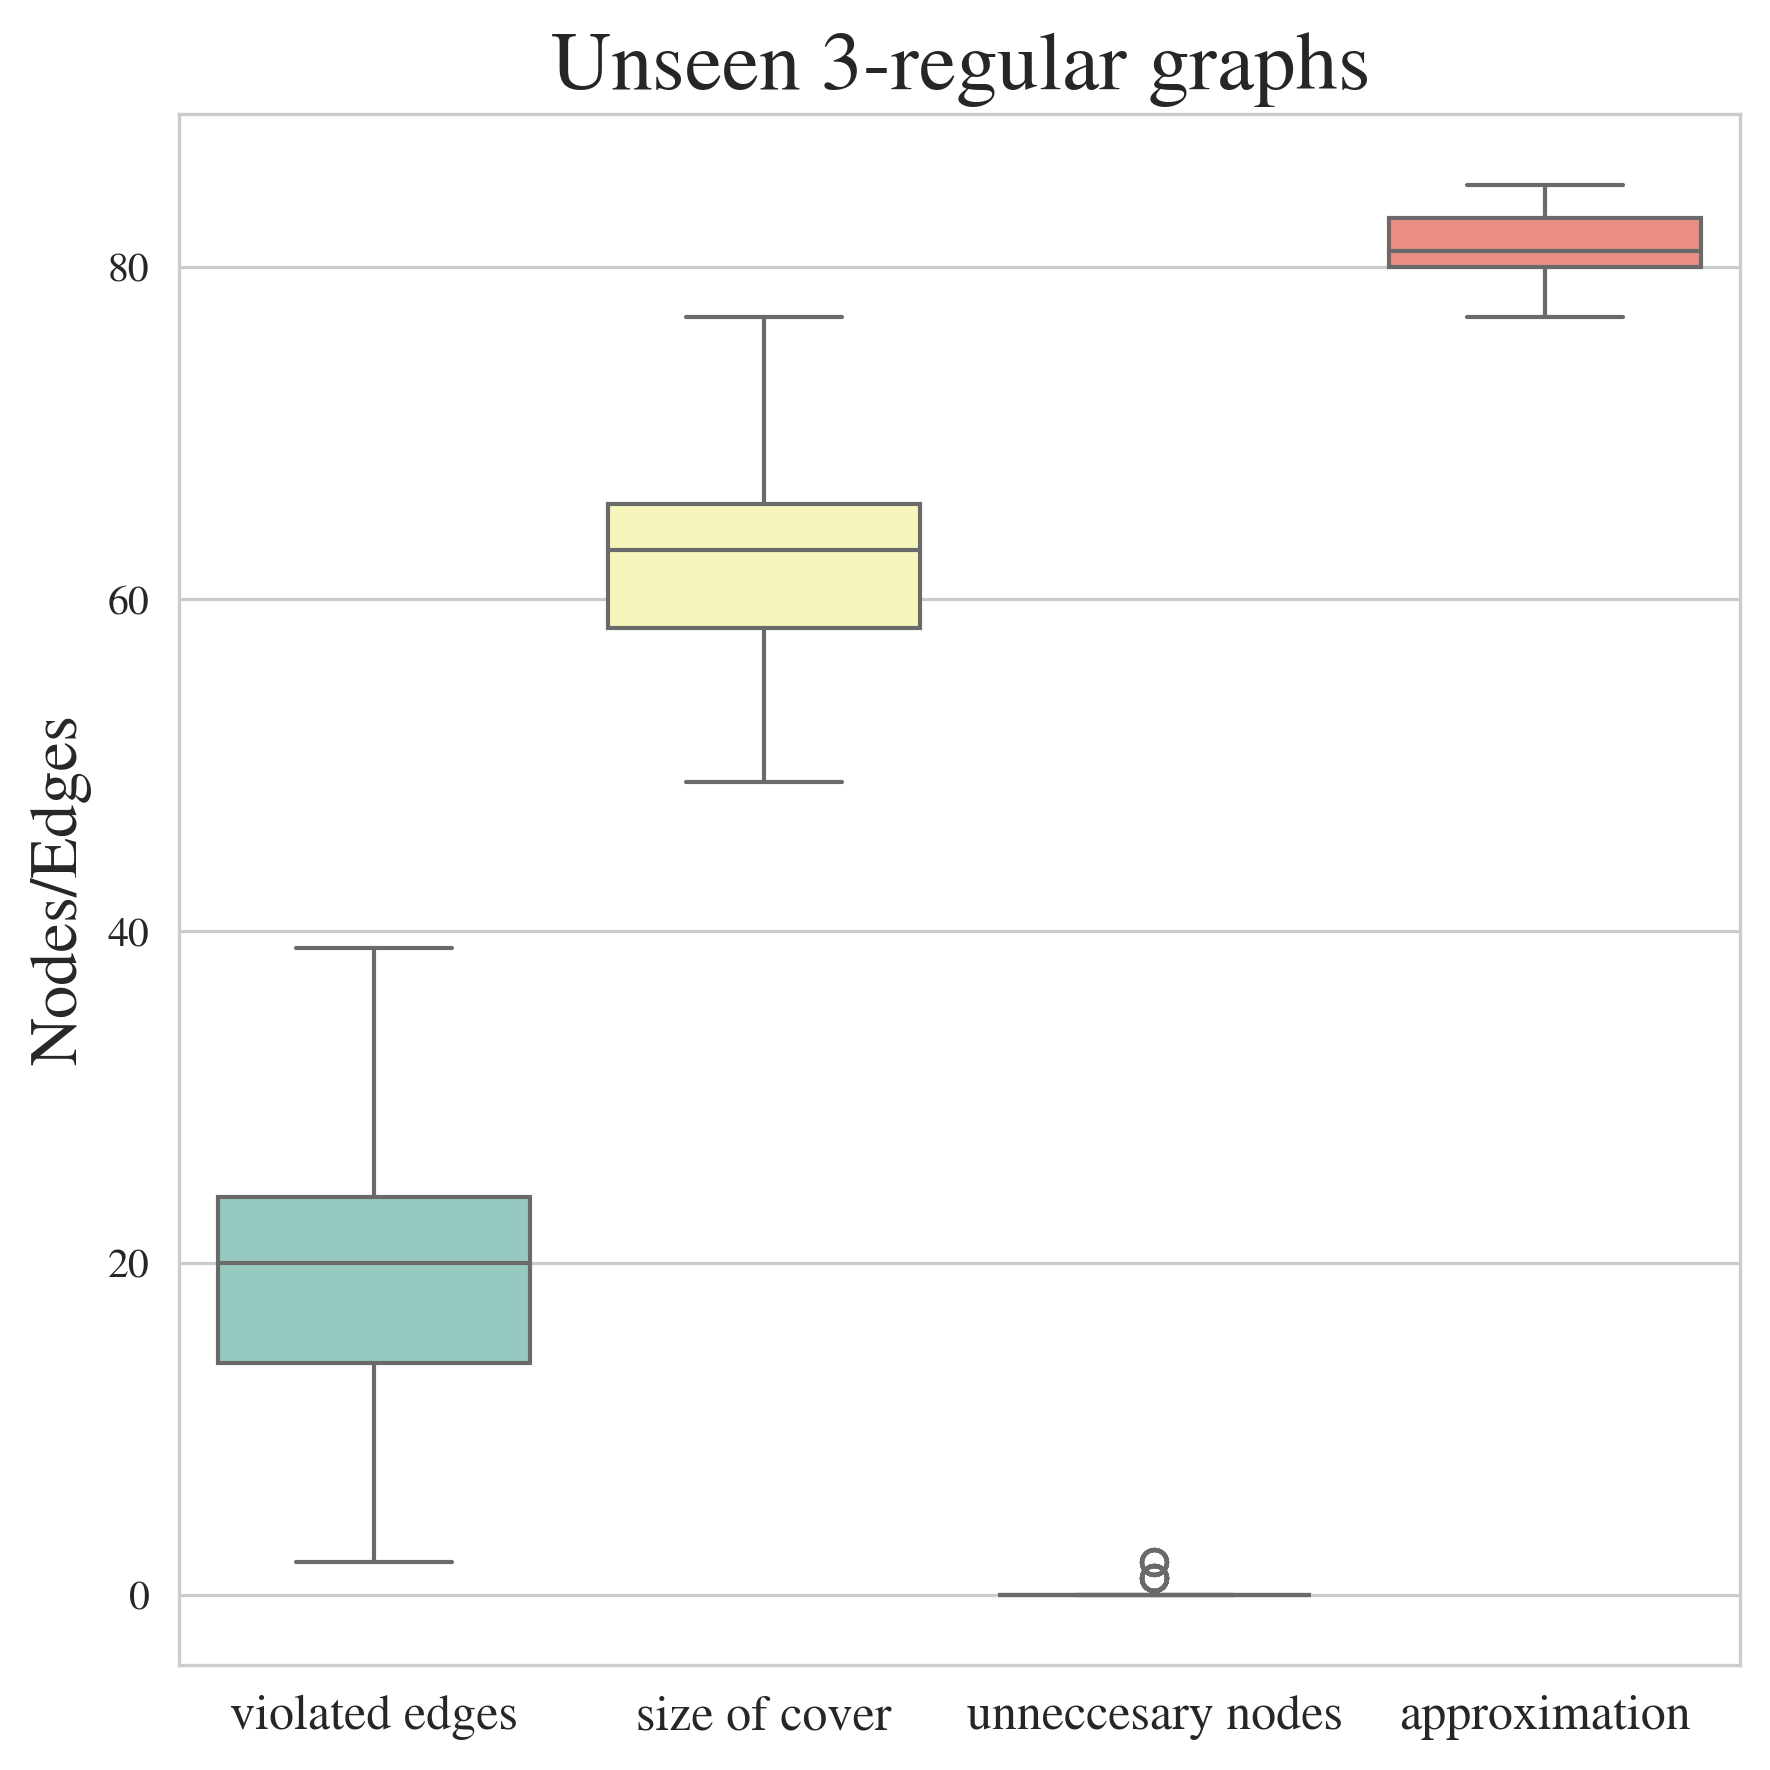

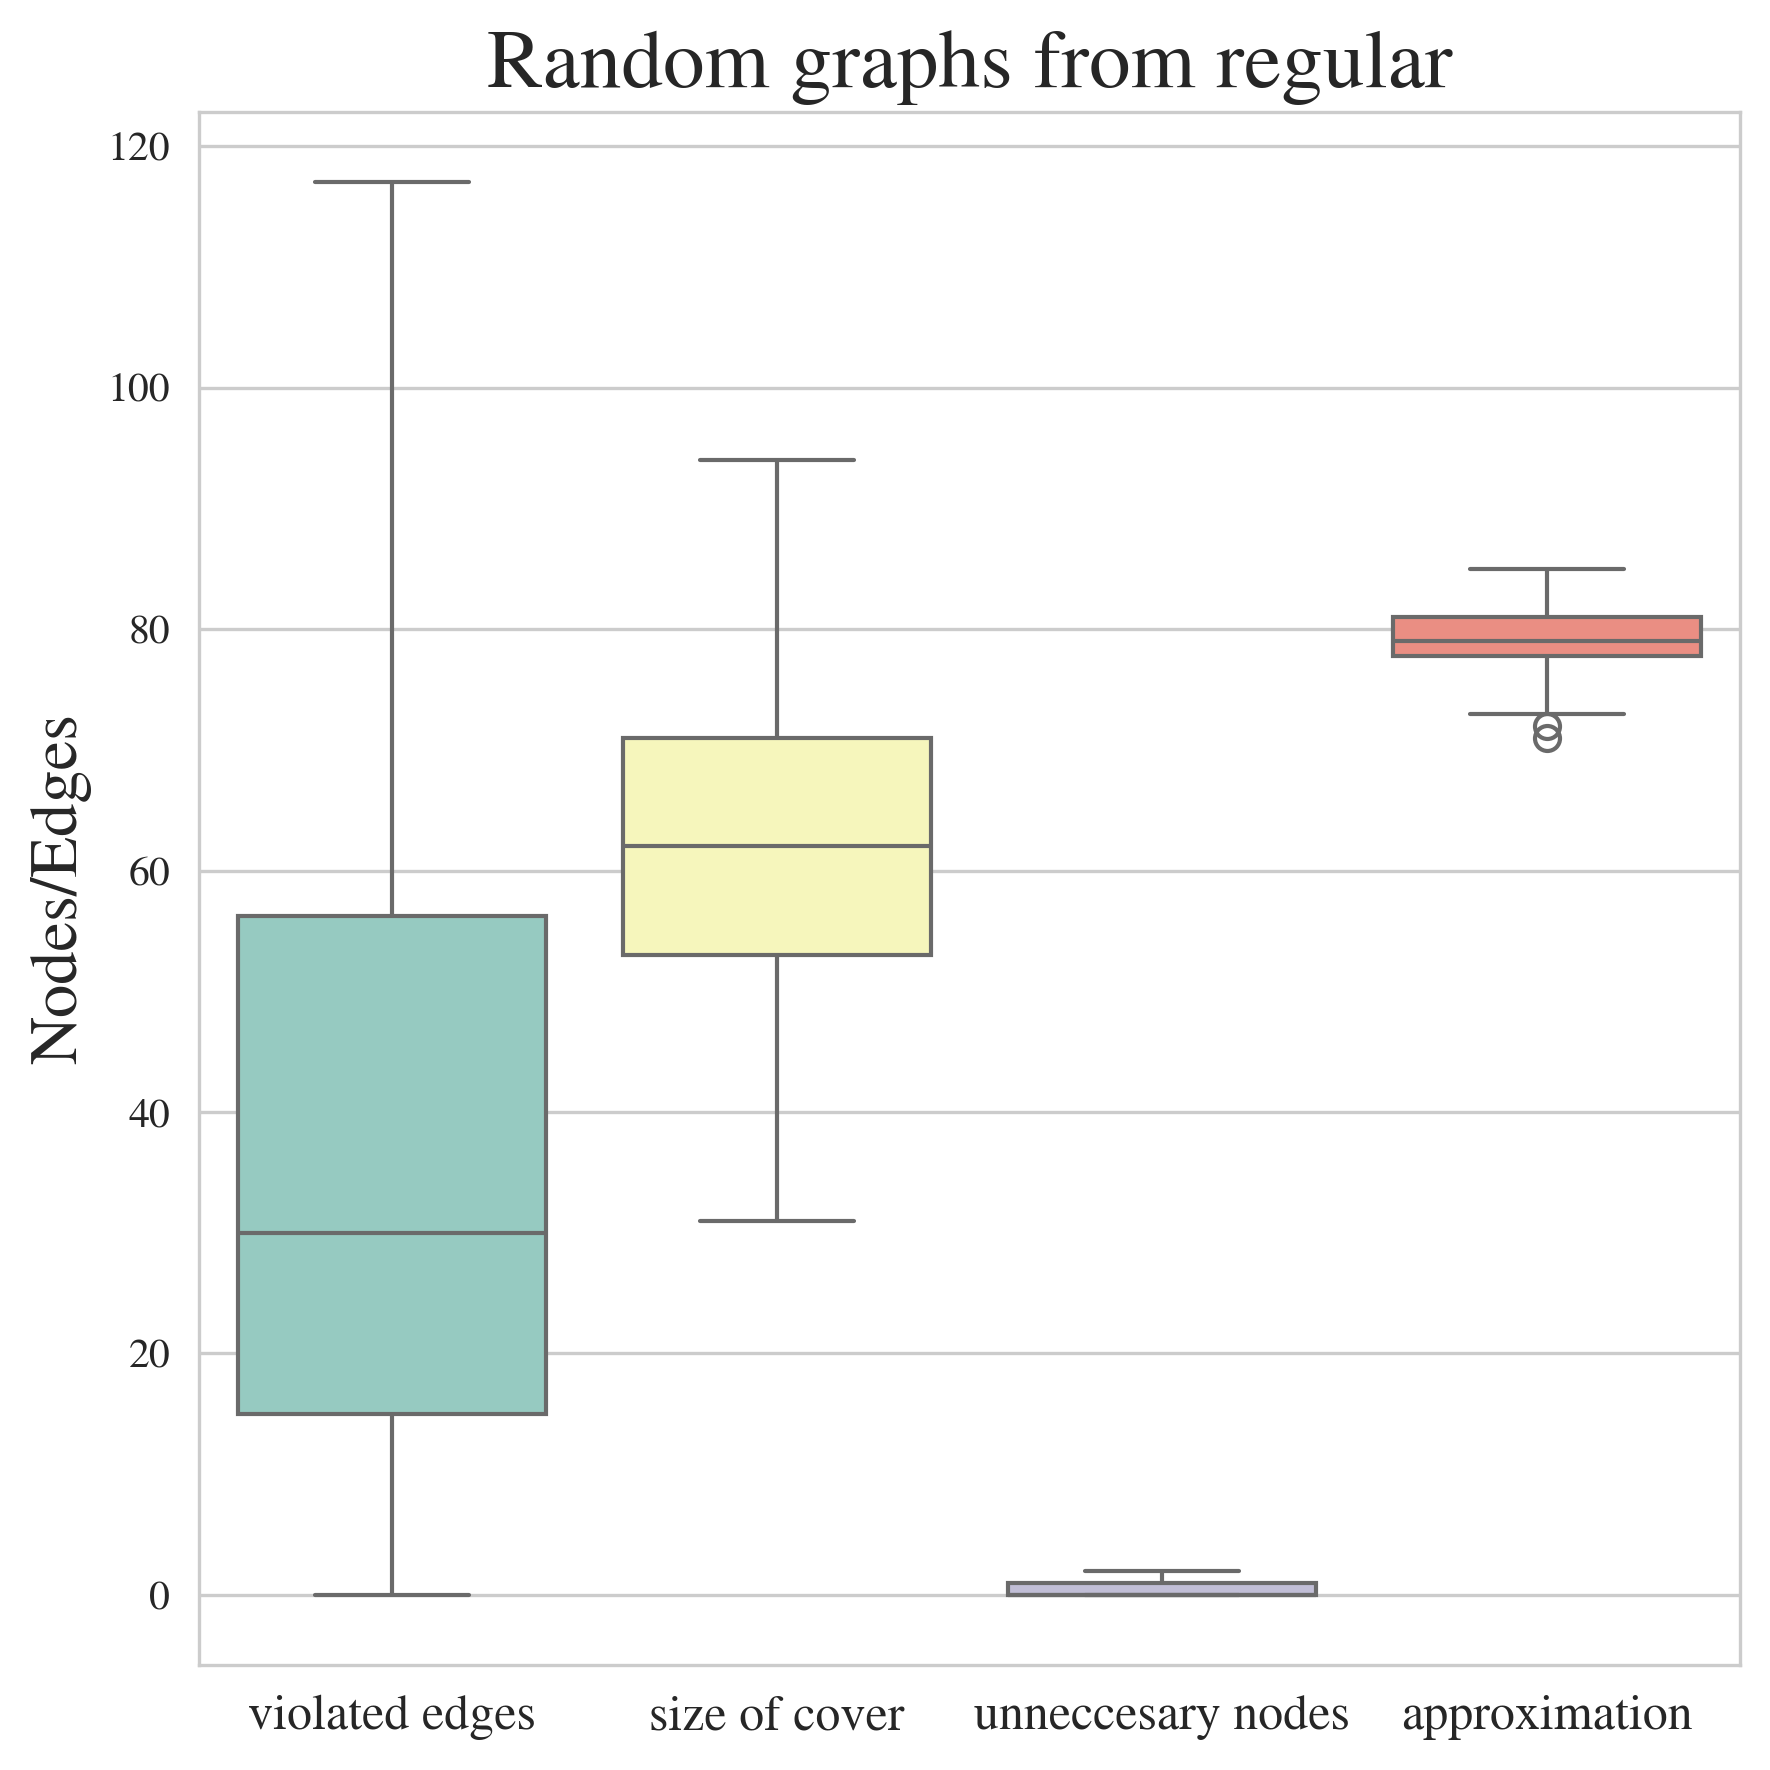

In [21]:
df_train_regular = predict_graph_df(training_regular_graphs, reg_state)
df_val_random = predict_graph_df(validation_random_graphs, reg_state)
df_val_regular = predict_graph_df(validation_regular_graphs, reg_state)

seen_vs_unseen_mvc_graphs(
    [df_train_regular, df_val_regular],
    ["Training regular graphs", "Unseen regular graphs"],
    suptitle="MVC trained on regular graphs ($d=3$)",
    savename="mvc_regular_boxes",
)

single_boxplot(
    df_train_regular,
    title="Training $3$-regular graphs",
    savename="mvc_train_regular",
)

single_boxplot(
    df_val_regular,
    title="Unseen $3$-regular graphs",
    savename="mvc_regular_to_regular",
)

single_boxplot(
    df_val_random,
    title="Random graphs from regular",
    savename="mvc_regular_to_random",
)

In [14]:
df_train_random

,violated edges,size of cover,unneccesary nodes,approximation
0,0.0,67.0,0.0,80.0
1,0.0,60.0,0.0,77.0
2,0.0,63.0,0.0,81.0
3,0.0,61.0,0.0,78.0
4,1.0,58.0,0.0,78.0
...,...,...,...,...
95,0.0,69.0,0.0,82.0
96,1.0,59.0,0.0,77.0
97,3.0,60.0,0.0,75.0
98,0.0,65.0,0.0,79.0
